In [3]:
# Importacion de librerias
# Conexión a la base de datos
# ==========================================
import os
import sys
import pathlib


sys.path.append(
    os.path.join(pathlib.Path(os.getcwd()).parent)
)


from utils.bq_conn import bq_conn_file

bq_client = bq_conn_file(project_id="dsa-miad-365616")

# Tratamiento de datos
# ==========================================
import pandas as pd
import numpy as np
from datetime import datetime

# Graficas
# ==========================================
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import seaborn as sns

# Modelos ML
# ==========================================
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from IPython.display import display

from sklearn.feature_extraction.text import TfidfVectorizer

## Importo data

In [4]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)

El número de filas del dataset: 26553
El número de columnas del dataset: 38


,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,departamento_ejecucion,numero_de_proceso,numero_de_contrato,cuantia_proceso,id_grupo,nombre_grupo,id_familia,nombre_familia,id_clase,nombre_clase,id_adjudicacion,tipo_identifi_del_contratista,identificacion_del_contratista,nom_razon_social_contratista,tipo_doc_representante_legal,identific_representante_legal,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,cundinamarca,CPMMSFFAMCNo01DE2019,CPMMSFFAMCNO01DE2019,50000000,E,productos de uso final,5022,productos de cereales legumbres,502213,harina productos de molinos,8143424,nit de persona juridica,900791326,inversiones ocazo,cedula de ciudadania,1022363447,330,330,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA184DE2019,184DE2019,22980096902,E,productos de uso final,5310,ropa,531027,uniformes,9226352,nit de persona juridica,860020227,fondo rotatorio de la policia forpo,nit de persona juridica,860020227,660,690,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA188DE2019,188DE2019,35998452,E,productos de uso final,5510,medios impresos,551015,publicaciones impresas,9265538,nit de persona juridica,830001113,imprenta nacional de colombia,nit de persona juridica,830001113,31,71,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA106DE2019,106DE2019,16767536,F,servicios,7210,servicios de mantenimiento reparaciones de con...,721015,servicios de apoyo para la construccion,8644918,nit de persona juridica,860025639,mitsubishi electric de colombia limitada,nit de persona juridica,860025639,170,170,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,bogota,CONVENIODEASOCIACIÓN231DE2018,231DE2018,0,F,servicios,7318,servicios de maquinado procesado,731810,servicios de maquinado,8059861,nit de persona juridica,806011019,recuperaciones naranjo recycling sas,cedula de ciudadania,57439563,360,360,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


In [5]:
secopI_filter = secop_I.filter(items=['id_modalidad','estado_del_proceso','id_objeto_a_contratar','tipo_de_contrato',
                                      'departamento_ejecucion','cuantia_proceso','id_grupo', 'detalle_del_objeto_a_contratar',
                                      'id_familia','id_clase','prorrogado','plazo_de_ejec_del_contrato_'
                                      ])
secopI_filter.head(5)

,id_modalidad,estado_del_proceso,id_objeto_a_contratar,tipo_de_contrato,departamento_ejecucion,cuantia_proceso,id_grupo,detalle_del_objeto_a_contratar,id_familia,id_clase,prorrogado,plazo_de_ejec_del_contrato_
0,13,celebrado,50000000,suministro,cundinamarca,50000000,E,contratar servicio suministro elementos materi...,5022,502213,0,330
1,12,celebrado,53000000,prestacion de servicios,bogota,22980096902,E,adquisicion uniformes para dotar personal cuer...,5310,531027,1,660
2,12,celebrado,55000000,prestacion de servicios,bogota,35998452,E,contratar diseno produccion tarjetas presentac...,5510,551015,1,31
3,12,liquidado,72000000,prestacion de servicios,bogota,16767536,F,prestar servicio mantenimiento preventivo corr...,7210,721015,0,170
4,19,celebrado,73000000,no encontrado en hoja proceso,bogota,0,F,desintegracion vehiculos automotores estado in...,7318,731810,0,360


In [6]:
secopI_filter['estado_del_proceso'] = secopI_filter['estado_del_proceso'].astype('category')
secopI_filter['tipo_de_contrato'] = secopI_filter['tipo_de_contrato'].astype('category')
secopI_filter['departamento_ejecucion'] = secopI_filter['departamento_ejecucion'].astype('category')
secopI_filter['id_grupo'] = secopI_filter['id_grupo'].astype('category')
secopI_filter['id_familia'] = secopI_filter['id_familia'].astype('category')
secopI_filter['id_clase'] = secopI_filter['id_clase'].astype('category')
secopI_filter['plazo_de_ejec_del_contrato_'] = secopI_filter['plazo_de_ejec_del_contrato_'].astype('category')

In [7]:
# conjunto de datos train
X_train = secopI_filter.drop(['prorrogado','detalle_del_objeto_a_contratar'], axis=1)
y_prorroga = secopI_filter[['prorrogado','detalle_del_objeto_a_contratar']]


## Preprocesamiento - Pipeline y ColumnTransformer


Las clases ColumnTransformer y make_column_transformer del módulo sklearn.compose permiten combinar múltiples transformaciones de preprocesado, especificando a qué columnas se aplica cada una. Como todo transformer, tiene un método de entrenamiento (fit) y otro de transformación (transform) . Esto permite que el aprendizaje de las transformaciones se haga únicamente con observaciones de entrenamiento, y se puedan aplicar después a cualquier conjunto de datos. La idea detrás de este módulo es la siguiente:

Definir todas las transformaciones (escalado, selección, filtrado...) que se desea aplicar y a qué columnas ColumnTransformer(). La selección de columnas puede hacerse por: nombre. índice, máscara booleana, slice, patrón regex, por tipo de columna o con las funciones de selección make_column_selector.

Aprender los parámetros necesarios para dichas transformaciones con las observaciones de entrenamiento .fit().

Aplicar las transformaciones aprendidas a cualquier conjunto de datos .transform().

In [8]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

secopI_filter_prep = preprocessor.fit_transform(X_train)

In [9]:
secopI_filter_prep = pd.concat([secopI_filter_prep, y_prorroga], axis=1)
secopI_filter_prep['prorrogado'].value_counts()

0    25823
1      730
Name: prorrogado, dtype: Int64

### Conjunto de datos en *train* y *test*

Se particiona el conjunto de datos dos subconjuntos de datos, *train* que es el conjunto de datos utilizados para entrenar los modelos el cual representa el 80% de los datos totales y *test* para comprobar el rendimiento de los modelos que representa el 20% restante. 

In [10]:
# conjunto de datos train
train_datos = secopI_filter_prep.sample(frac=0.9,random_state=0)
# conjunto de datos test
test_datos = secopI_filter_prep.drop(train_datos.index)

In [11]:
train_datos.head(2)

,id_modalidad,id_objeto_a_contratar,cuantia_proceso,estado_del_proceso_adjudicado,estado_del_proceso_borrador,estado_del_proceso_celebrado,estado_del_proceso_convocado,estado_del_proceso_descartado,estado_del_proceso_liquidado,estado_del_proceso_terminado sin liquidar,tipo_de_contrato_acuerdo marco,tipo_de_contrato_arrendamiento,tipo_de_contrato_comodato,tipo_de_contrato_compraventa,tipo_de_contrato_concesion,tipo_de_contrato_consultoria,tipo_de_contrato_no encontrado en hoja proceso,tipo_de_contrato_obra,tipo_de_contrato_otro tipo de contrato,tipo_de_contrato_prestacion de servicios,tipo_de_contrato_suministro,departamento_ejecucion_amazonas,departamento_ejecucion_antioquia,departamento_ejecucion_arauca,departamento_ejecucion_atlantico,departamento_ejecucion_bogota,departamento_ejecucion_bolivar,departamento_ejecucion_boyaca,departamento_ejecucion_caldas,departamento_ejecucion_caqueta,departamento_ejecucion_casanare,departamento_ejecucion_cauca,departamento_ejecucion_cesar,departamento_ejecucion_choco,departamento_ejecucion_colombia,departamento_ejecucion_cordoba,departamento_ejecucion_cundinamarca,departamento_ejecucion_huila,departamento_ejecucion_la guajira,departamento_ejecucion_magdalena,departamento_ejecucion_meta,departamento_ejecucion_narino,departamento_ejecucion_norte de santander,departamento_ejecucion_otros paises,departamento_ejecucion_putumayo,departamento_ejecucion_quindio,departamento_ejecucion_risaralda,departamento_ejecucion_san andres,departamento_ejecucion_santander,departamento_ejecucion_sucre,departamento_ejecucion_tolima,departamento_ejecucion_valle del cauca,id_grupo_A,id_grupo_B,id_grupo_C,id_grupo_D,id_grupo_E,id_grupo_F,id_grupo_G,id_familia_1010,id_familia_1011,id_familia_1012,id_familia_1015,id_familia_1016,id_familia_1017,id_familia_1019,id_familia_1042,id_familia_1110,id_familia_1111,id_familia_1112,id_familia_1113,id_familia_1115,id_familia_1116,id_familia_1117,id_familia_1213,id_familia_1214,id_familia_1216,id_familia_1217,id_familia_1218,id_familia_1219,id_familia_1235,id_familia_1310,id_familia_1311,id_familia_1410,id_familia_1411,id_familia_1412,id_familia_1510,id_familia_1511,id_familia_1512,id_familia_2010,id_familia_2011,id_familia_2012,id_familia_2014,id_familia_2110,id_familia_2210,id_familia_2310,id_familia_2312,id_familia_2313,id_familia_2314,id_familia_2315,id_familia_2316,id_familia_2318,id_familia_2319,id_familia_2323,id_familia_2326,id_familia_2327,id_familia_2329,id_familia_2330,id_familia_2410,id_familia_2411,id_familia_2412,id_familia_2413,id_familia_2414,id_familia_2510,id_familia_2517,id_familia_2519,id_familia_2610,id_familia_2611,id_familia_2612,id_familia_2613,id_familia_2711,id_familia_2712,id_familia_2713,id_familia_2714,id_familia_3010,id_familia_3011,id_familia_3013,id_familia_3014,id_familia_3015,id_familia_3016,id_familia_3017,id_familia_3018,id_familia_3019,id_familia_3024,id_familia_3026,id_familia_3110,id_familia_3111,id_familia_3114,id_familia_3115,id_familia_3116,id_familia_3117,id_familia_3118,id_familia_3119,id_familia_3120,id_familia_3121,id_familia_3123,id_familia_3126,id_familia_3128,id_familia_3135,id_familia_3137,id_familia_3140,id_familia_3141,id_familia_3210,id_familia_3211,id_familia_3212,id_familia_3213,id_familia_3214,id_familia_3215,id_familia_3910,id_familia_3911,id_familia_3912,id_familia_3913,id_familia_4010,id_familia_4014,id_familia_4015,id_familia_4016,id_familia_4017,id_familia_4018,id_familia_4110,id_familia_4111,id_familia_4212,id_familia_4213,id_familia_4214,id_familia_4215,id_familia_4216,id_familia_4217,id_familia_4218,id_familia_4219,id_familia_4222,id_familia_4224,id_familia_4225,id_familia_4226,id_familia_4229,id_familia_4231,id_familia_4319,id_familia_4320,id_familia_4321,id_familia_4322,id_familia_4323,id_familia_4410,id_familia_4411,id_familia_4412,id_familia_4510,id_familia_4511,id_familia_4512,id_familia_4513,id_familia_4610,id_familia_4615,id_familia_4616,id_familia_4617,id_familia_4618,id_familia_4619,id_familia_4710,id_famili

## Modelos Clasificación

In [27]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(train_datos,
          target = 'prorrogado', 
          train_size= 0.8,
          fold=5,
          session_id = 123)
models()

,Description,Value
0,Session id,123
1,Target,prorrogado
2,Target type,Binary
3,Original data shape,"(23898, 1693)"
4,Transformed data shape,"(23898, 1693)"
5,Transformed train set shape,"(19118, 1693)"
6,Transformed test set shape,"(4780, 1693)"
7,Numeric features,1691
8,Categorical features,1
9,Preprocess,True


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [28]:
# compare models
best = compare_models(probability_threshold = 0.25)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9746,0.8681,0.2561,0.6144,0.3613,0.3506,0.3861,0.8360
ridge,Ridge Classifier,0.9727,0.0000,0.0710,0.5921,0.1264,0.1212,0.1975,0.7660
svm,SVM - Linear Kernel,0.9725,0.0000,0.0692,0.6163,0.1227,0.1175,0.1961,0.5020
lr,Logistic Regression,0.9722,0.8142,0.1869,0.5092,0.2733,0.2622,0.2972,3.1100
dummy,Dummy Classifier,0.9720,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4820
gbc,Gradient Boosting Classifier,0.9713,0.8328,0.2280,0.4734,0.3077,0.2948,0.3156,0.8180
lightgbm,Light Gradient Boosting Machine,0.9713,0.8691,0.3290,0.4808,0.3900,0.3759,0.3833,0.6040
xgboost,Extreme Gradient Boosting,0.9702,0.8632,0.3159,0.4526,0.3718,0.3570,0.3633,0.4940
rf,Random Forest Classifier,0.9678,0.8278,0.3477,0.4156,0.3779,0.3615,0.3634,0.5680
knn,K Neighbors Classifier,0.9637,0.7208,0.3290,0.3491,0.3377,0.3191,0.3198,4.9520


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

### Mejor modelo

In [21]:
print(best)

CustomProbabilityThresholdClassifier(alpha=1.0, class_weight=None,
                                     classifier=RidgeClassifier(alpha=1.0,
                                                                class_weight=None,
                                                                copy_X=True,
                                                                fit_intercept=True,
                                                                max_iter=None,
                                                                positive=False,
                                                                random_state=123,
                                                                solver='auto',
                                                                tol=0.0001),
                                     copy_X=True, fit_intercept=True,
                                     max_iter=None, positive=False,
                                     probability_threshold=0.25,
              

## Analizar Modelo - Metricas


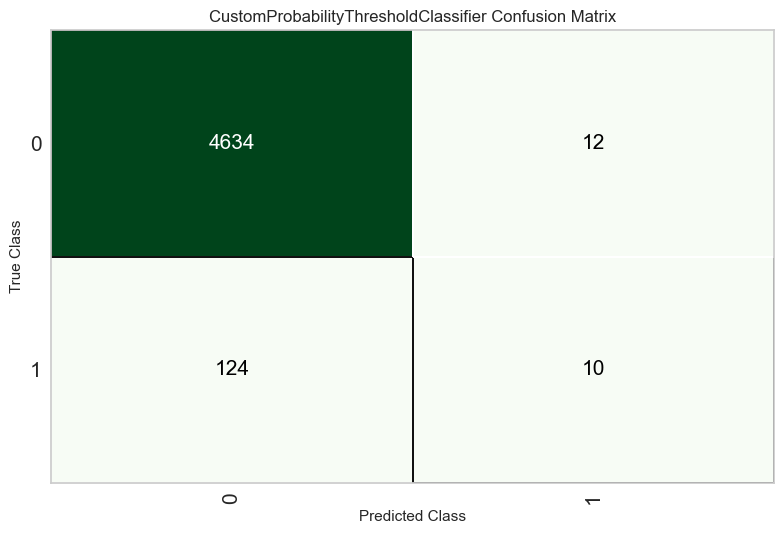

In [16]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

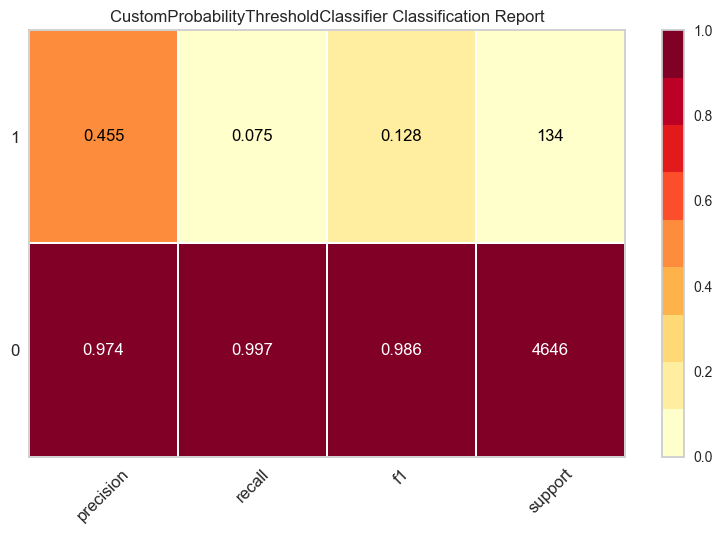

In [17]:
# plot confusion matrix
plot_model(best, plot = 'class_report')

In [19]:
# plot AUC
plot_model(best, plot = 'auc')

TypeError: AUC plot not available for estimators with no predict_proba attribute.

## Feature importance

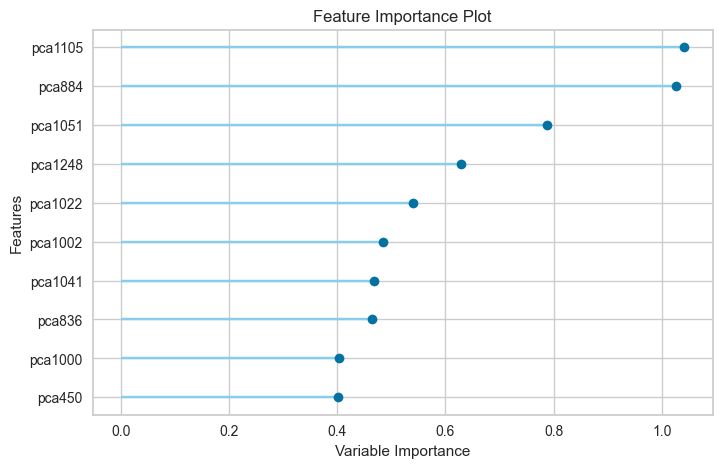

In [22]:
# plot feature importance
plot_model(best, plot = 'feature')


## Predicción
La `predict_model` función devuelve `prediction_labely` prediction_score(probabilidad de la clase predicha) como nuevas columnas en el marco de datos. Cuando los datos son None(predeterminado), utiliza el conjunto de prueba (creado durante la función de configuración) para la puntuación.

In [23]:
# predict on test set
holdout_pred = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.9715,0.5360,0.0746,0.4545,0.1282,0.1213,0.1757


In [24]:
# show predictions df
holdout_pred.loc[holdout_pred.prorrogado==1,['prorrogado', 'prediction_label', 'prediction_score']][0:50]

KeyError: "['prediction_score'] not in index"

In [43]:
# copy data and drop Class variable
new_data = test_datos
new_data.drop('prorrogado', axis=1, inplace=True)
new_data.head()

,id_modalidad,id_objeto_a_contratar,cuantia_proceso,estado_del_proceso_adjudicado,estado_del_proceso_borrador,estado_del_proceso_celebrado,estado_del_proceso_convocado,estado_del_proceso_descartado,estado_del_proceso_liquidado,estado_del_proceso_terminado sin liquidar,...,plazo_de_ejec_del_contrato__1095,plazo_de_ejec_del_contrato__1170,plazo_de_ejec_del_contrato__1200,plazo_de_ejec_del_contrato__1800,plazo_de_ejec_del_contrato__2700,plazo_de_ejec_del_contrato__4980,plazo_de_ejec_del_contrato__5280,plazo_de_ejec_del_contrato__6690,plazo_de_ejec_del_contrato__7500,detalle_del_objeto_a_contratar
43,-1.575413,1.625498,-0.096261,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prestar servicios personales profesionales com...
52,-1.575413,1.625498,-0.101577,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prestar servicios personales profesionales com...
55,-1.575413,1.625498,-0.093602,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prestar servicios personales profesionales com...
62,-1.575413,1.625498,-0.099531,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prestar servicios personales profesionales com...
63,-1.575413,1.625498,-0.090944,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prestar servicios personales profesionales com...


In [44]:
# predict model on new_data
predictions = predict_model(best, data = new_data)
predictions.head()

,id_modalidad,id_objeto_a_contratar,cuantia_proceso,estado_del_proceso_adjudicado,estado_del_proceso_borrador,estado_del_proceso_celebrado,estado_del_proceso_convocado,estado_del_proceso_descartado,estado_del_proceso_liquidado,estado_del_proceso_terminado sin liquidar,...,plazo_de_ejec_del_contrato__1200,plazo_de_ejec_del_contrato__1800,plazo_de_ejec_del_contrato__2700,plazo_de_ejec_del_contrato__4980,plazo_de_ejec_del_contrato__5280,plazo_de_ejec_del_contrato__6690,plazo_de_ejec_del_contrato__7500,detalle_del_objeto_a_contratar,prediction_label,prediction_score
43,-1.575413,1.625498,-0.096261,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prestar servicios personales profesionales com...,0,0.9979
52,-1.575413,1.625498,-0.101577,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prestar servicios personales profesionales com...,0,0.9989
55,-1.575413,1.625498,-0.093602,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prestar servicios personales profesionales com...,0,0.9985
62,-1.575413,1.625498,-0.099531,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prestar servicios personales profesionales com...,0,0.9982
63,-1.575413,1.625498,-0.090944,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,prestar servicios personales profesionales com...,0,0.9970


In [66]:
from sklearn.metrics import confusion_matrix, classification_report

pred_y = predictions.prediction_label
y_test = test_datos.prorrogado
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      2594
         1.0       0.48      0.16      0.24        61

    accuracy                           0.98      2655
   macro avg       0.73      0.58      0.62      2655
weighted avg       0.97      0.98      0.97      2655

